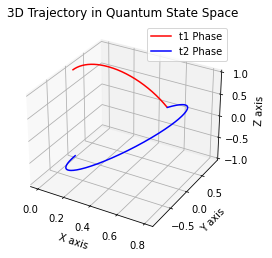

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



def compute_xyz(delta, epsilon, x0, y0, z0, t, t_switch):
    Omega = np.sqrt(1 + delta**2)

    x_t, y_t, z_t = [], [], []

    for ti in t:
        if ti >= t_switch:
            epsilon_eff = -epsilon
            sign_flip = -1
        else:
            epsilon_eff = epsilon
            sign_flip = 1

        A = y0
        B = (delta * x0 - epsilon_eff * z0) / Omega

        x = sign_flip * (x0 - (delta * B / Omega) - (delta / Omega) * (A * np.sin(Omega * ti) - B * np.cos(Omega * ti)))
        y = sign_flip * (A * np.cos(Omega * ti) + B * np.sin(Omega * ti))
        z = sign_flip * (z0 + (epsilon_eff * B / Omega) + (epsilon_eff / Omega) * (A * np.sin(Omega * ti) - B * np.cos(Omega * ti)))

        x_t.append(x)
        y_t.append(y)
        z_t.append(z)

    return np.array(x_t), np.array(y_t), np.array(z_t)

# Set parameters
delta = -0.5
epsilon = -1
x0, y0, z0 = 0, 0, 1

# Control times
t1 = (np.pi - np.arccos(delta**2)) / np.sqrt(1 + delta**2)
t2 = (np.pi + np.arccos(delta**2)) / np.sqrt(1 + delta**2)
t_switch = t1

t_total = t1 + t2

# t1arr = np.linspace(0, t1, 500)
# t2arr = np.linspace(t1arr[499], t_total, 500)
# t2arr = t2arr[1:]
# t = np.concatenate((t1arr, t2arr))

t = np.linspace(0,t_total, 500)

# Compute trajectories
x, y, z = compute_xyz(delta, epsilon, x0, y0, z0, t, t_switch)

# Save data to a CSV file
data = pd.DataFrame({'Time': t, 'X': x, 'Y': y, 'Z': z})
data.to_csv('quantum_system_trajectory.csv', index=False)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
split_index = np.argmin(np.abs(t - t1))
ax.plot(x[:split_index], y[:split_index], z[:split_index], color='red', label='t1 Phase')
ax.plot(x[split_index:], y[split_index:], z[split_index:], color='blue', label='t2 Phase')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Trajectory in Quantum State Space')
ax.legend()

# Set a higher resolution (dpi) for the saved figure
plt.savefig("3d_high_resolution.png", dpi=300)  # You can adjust the dpi value as needed
plt.show()




In [19]:
from matplotlib.animation import FuncAnimation

# Initialization function for the animation
def init():
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Trajectory in Quantum State Space')

# Animation function, updates the plot for each frame
def animate(i):
    ax.clear()

    # Plot points up to the current frame
    # Points in t1arr
    ax.scatter(x[:i][t[:i] <= t1], y[:i][t[:i] <= t1], z[:i][t[:i] <= t1], color='red')
    
    # Points in t2arr
    ax.scatter(x[:i][t[:i] > t1], y[:i][t[:i] > t1], z[:i][t[:i] > t1], color='blue')
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Trajectory in Quantum State Space')

# Create the animation
ani = FuncAnimation(fig, animate, frames=len(t), init_func=init, blit=False, interval=20)

# Save the animation
ani.save("bloch_transition.gif", writer='pillow', fps=45)

plt.show()


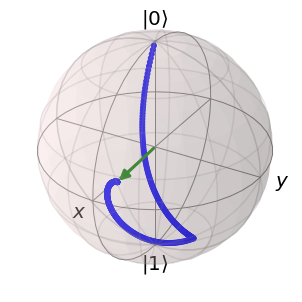

In [24]:
import numpy as np
from qutip import Qobj, Bloch
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

# Constants
gamma_em = 1.9  # Spontaneous emission rate
gamma_dep = 0.001 # Spontaneous dephasing rate
gamma_exc = 0.05 # Spontaneous excitation rate
delta = -0.5     # Detuning
h_bar = 1       # Reduced Planck constant (set to 1 for simplicity)
time_steps = 500
total_time = t_total  # Replace with the actual value of t*
dt = total_time / time_steps

# # Control field with five switches
# def u(t):
#     # Define switch points within the total duration
#     switch_points = [total_time * i / 5 for i in range(1, 6)]
    
#     # Initialize control value
#     control_value = 1  # Start with 1 or -1 depending on your initial condition

#     # Iterate over switch points and flip the control value at each switch
#     for switch in switch_points:
#         if t < switch:
#             break
#         control_value *= -1  # Flip the control value

#     return control_value

# Control field with one switch
def u(t):
    # Determine the value of the control field based on the switch point
    control_value = 1 if t < t_switch else -1
    return control_value



# Initial state as a complex matrix
rho = np.array([[1+0j, 0+0j], [0+0j, 0+0j]])

# Function to compute the derivative d(rho)/dt
def drho_dt(rho, t):
    H = 1/2 * np.array([[delta, u(t)], [u(t), -delta]])   # Hamiltonian
    sigma_minus = np.array([[0, 0], [1, 0]])                # Lowering operator
    sigma_plus = np.array([[0, 1], [0, 0]])                 # Raising operator
    sigma_z = np.array([[1,0],[0,-1]])
    # Hamiltonian contribution
    commutator = np.dot(H, rho) - np.dot(rho, H)
    hamiltonian_term = -1j * commutator / h_bar

    # Spontaneous emission contribution
    emission_term = gamma_em * (np.dot(np.dot(sigma_minus, rho), sigma_plus) -
                                0.5 * np.dot(sigma_plus @ sigma_minus, rho) -
                                0.5 * np.dot(rho, sigma_plus @ sigma_minus))
    # Dephasing contribution
    dephasing_term = gamma_dep * (np.dot(np.dot(sigma_z,rho), sigma_z) - 
                                        0.5 * np.dot(sigma_z @ sigma_z, rho) - 
                                        0.5 * np.dot(rho, sigma_z @ sigma_z) 
                                        )
    # Excitation contribution
    excitation_term = gamma_exc * (np.dot(np.dot(sigma_plus,rho), sigma_minus) -
                                          0.5 * np.dot(sigma_minus @ sigma_plus,rho) -
                                          0.5 * np.dot(rho, sigma_minus @ sigma_plus)
                                          )

    return hamiltonian_term + emission_term + dephasing_term + excitation_term

population_ground = []
population_excited = []
coherence = []
rho_list = []

# Time evolution
for t in np.linspace(0, total_time, time_steps):
    rho += drho_dt(rho, t) * dt
    rho_list.append(Qobj(rho))  # Append the current state to the list
    population_ground.append(np.real(rho[0, 0]))
    population_excited.append(np.real(rho[1, 1]))
    coherence_value = np.abs(rho[0, 1])  # Magnitude of the off-diagonal element
    coherence.append(coherence_value)


# Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

# Create a single figure for the animation
fig = plt.figure()
b = Bloch(fig=fig)

# Initialize a list to store trajectory points
trajectory = []

# Function to calculate the Bloch vector from a density matrix
def bloch_vector_from_density_matrix(rho):
    x = np.trace(np.dot(sigma_x, rho)).real
    y = np.trace(np.dot(sigma_y, rho)).real
    z = np.trace(np.dot(sigma_z, rho)).real
    return [x, y, z]

# Add all states to the Bloch object and store trajectory points
for state in rho_list:
    # Convert state to Qobj if not already
    if not isinstance(state, Qobj):
        state = Qobj(state)
    b.add_states(state)

    # Calculate Bloch vector components
    vec = bloch_vector_from_density_matrix(state.full())
    trajectory.append(vec)

# Function to update the Bloch sphere for the animation
def update_bloch(num, bloch, states, trajectory):
    bloch.clear()  # Clear the previous state
    bloch.add_states(states[num])  # Add the new state

    # Add trajectory up to the current frame
    x_vals = [vec[0] for vec in trajectory[:num+1]]
    y_vals = [vec[1] for vec in trajectory[:num+1]]
    z_vals = [vec[2] for vec in trajectory[:num+1]]
    bloch.add_points([x_vals, y_vals, z_vals])  # Add trajectory points

    bloch.make_sphere()  # Re-render the Bloch sphere
    return bloch.fig

# Set up the animation
ani = FuncAnimation(fig, update_bloch, frames=len(rho_list), 
                    fargs=(b, rho_list, trajectory), repeat=False)

# Save the animation as a video
ani.save("bloch_transition.gif", writer='pillow', fps=30)

plt.show()

In [25]:
rho

array([[ 0.16883897+0.j        , -0.13692646+0.27508498j],
       [-0.13692646-0.27508498j,  0.83116103+0.j        ]])

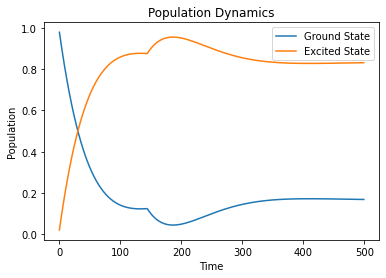

In [26]:
# Assuming 'population_ground' and 'population_excited' are lists containing the population data over time
plt.plot(population_ground, label='Ground State')
plt.plot(population_excited, label='Excited State')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Population Dynamics')
plt.legend()
plt.savefig("polulation dynamics", dpi = 300)
plt.show()


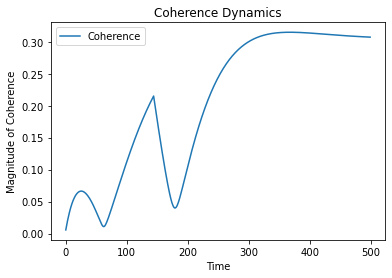

In [27]:
# Assuming 'coherence' is a list containing the coherence data over time
plt.plot(coherence, label='Coherence')
plt.xlabel('Time')
plt.ylabel('Magnitude of Coherence')
plt.title('Coherence Dynamics')
plt.savefig('Cohenrence Dynamcis', dpi = 300)
plt.legend()
plt.show()
